| Übungszettel 6 | Einführung in die Numerik |
|---|---|
| Dozent      | Prof. Kanschat |
| Tutoren     | S. Meggendorfer und J. Witte |
| Abgabe      | bis 27.05.21 23.15 Uhr |
| Studierende | Daniel Schiller, Thomas Blankenburg, Dennis Jakob |


---

### Aufgabe 1: kubische Spline-Interpolation

Wir betrachten erneut die Runge-Funktion 
$$ f(x) = \frac{1}{1+x^2}, \quad x \in [-5,5]. $$

1. Berechnen Sie die kubische Spline-Interpolation $s \in S^{(3,2)}_h$ von $f$ zu den äquidistanten Stützstellen $x_0,\ldots,x_n$ und Funktionswerten $f_0,\ldots,f_n$ sowie natürliche Randbedingungen $s''(-5) = s''(5) = 0$:

    1. Berechnen Sie die Längen der Teilintervalle `hi`, das heißt $h_i = x_i - x_{i-1}$ für $i = 1,\ldots,n$.
    2. Definieren Sie eine Funktion `solve_moments(...)`, die die Momente `Mi`, d.h. $M_i = s''(x_i), i = 0,\ldots,n$, anhand des linearen Gleichungssystems aus der Vorlesung berechnet. Ein lineares Gleichungssystem lösen sie mit Hilfe von [numpy.linalg.solve](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) (hier `np.linalg.solve`).   
    3. Definieren Sie eine Funktion `s_i(...)`, die die Einschränkung der Spline-Interpolierenden $s$ auf dem Teilintervall $[x_{i-1},x_i]$ an der Stelle $x$ auswertet.
    4. Verwenden Sie `s_i(...)` und definieren Sie eine Funktion `spline(...)`, die die Auswertung der Spline-Interpolierenden $s$ an einer beliebigen Stelle $x \in [-5,5]$ auswertet.
    
2. Plotten Sie die Runge-Funktion $f$, die Spline-Interpolierende $s$, die Lagrange-Interpolierende $p$ zu den äquidistanten Stützstellen $x_0,\ldots,x_n$ und die Lagrange-Interpolierende $\hat p$ zu den Tschebyscheff-Stützstellen $\hat x_0,\ldots,\hat x_n$. Vergleichen Sie auch die Fehlerfunktionen $|f-s|$, $|f-p|$ und $|f-\hat p|$.

3. **Bonus** Berechnen Sie $N = \dim S^{(3,2)}_h$ (siehe Vorlesung) und wiederholen Sie 2. mit Lagrange-Interpolationen für äquidistante Stützstellen $x_0,\ldots,x_{N-1}$ sowie Tschebyscheff-Stützstellen $\hat x_0,\ldots,\hat x_{N-1}$.

*Die Ellipsis `...` ergänzen Sie durch benötigte Funktionsparameter.*

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

n = 4
a = -5.
b = 5.

def runge_func(x):
    return 1. / (1. + x**2)

xi = np.linspace(a,b,n+1)
fi = runge_func(xi)

---

Für die Lagrange-Interpolation können Sie folgende Funktionen vorheriger Übungsblätter verwenden.

In [2]:
def L(k,xi,x):
    "k-tes Lagrange Basispolynom zu den Stützstellen xi"
    Lx = 1.
    for j in range(len(xi)):
        if j != k:
            Lx *= (x-xi[j])/(xi[k]-xi[j])
    return Lx

def pLagr(xi,fi,x):
    "Lagrange Interpolationspolynom zu den Stützstellen xi mit Stützwerten fi"
    px = 0.
    for j in range(len(xi)):
        px += fi[j]*L(j,xi,x)
    return px

In [3]:
def make_cheb_xi(a,b,n):
    xi = np.zeros(n)
    alpha = (a+b)/2.
    beta = (b-a)/2.
    for i in range(n):
        xi[i] = alpha + beta * np.cos((2.*i+1.)/(2.*n)*np.pi)
    return xi

---

In [4]:
def get_hi(xi):
    hi = np.zeros(xi.size - 1)
    for i in range(hi.size):
        hi[i] = np.abs(xi[i+1] - xi[i])
    return hi # caution: hi[j] = h_{j + 1} in script

In [5]:
def solve_moments(hi, fi):
    lami = np.zeros(hi.size)
    for i in range(lami.size):
        if i == 0:
            lami[i] = 0.
        else:
            lami[i] = hi[i] / (hi[i-1] + hi[i])
    mui = np.zeros(lami.size)
    for i in range(mui.size):
        if i == (mui.size - 1):
            mui[i] = 0.
        else:
            mui[i] = 1. - lami[i + 1]
    di = np.zeros(fi.size)
    for i in range(di.size):
        if i == 0:
            di[i] = 0.
        elif i == (di.size - 1):
            di[i] = 0.
        else:
            di[i] = (6. / (hi[i - 1] + hi[i])) * (((fi[i + 1] - fi[i]) / hi[i]) - ((fi[i] - fi[i-1]) / hi[i - 1]))
    A = np.diag(2. * np.ones(fi.size))
    for i in range(lami.size):
        A[i][i+1] = lami[i]
    for i in range(mui.size):
        A[i+1][i] = mui[i]
    #print(A)
    mi = np.linalg.solve(A, di)
    return mi

In [6]:
def s_i(x, i, xi, fi, hi, mi):
    a0 = fi[i]
    a1 = ((fi[i] - fi[i-1]) / hi[i-1]) + (hi[i-1] * (2. * mi[i] + mi[i-1]) / 6.)
    a2 = mi[i] / 2.
    a3 = (mi[i] - mi[i-1]) / (6. * hi[i-1])
    return a0 + a1 * (x - xi[i]) + a2 * (x - xi[i])**2 + a3 * (x - xi[i])**3

In [7]:
def spline(x, xi, fi):
    foundI = False
    i = 1
    while foundI == False:
        if (x >= xi[i - 1]) & (x <= xi[i]):
            foundI = True
        else:
            i += 1
    hi = get_hi(xi)
    mi = solve_moments(hi, fi)
    return s_i(x, i, xi, fi, hi, mi)    

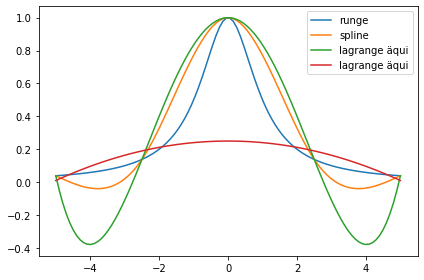

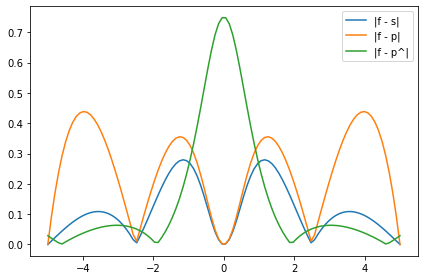

In [8]:
x_lin = np.linspace(a, b, 100)

plt.figure()

# runge
plt.plot(x_lin, runge_func(x_lin), label = 'runge')

# split
y_spline = np.zeros(x_lin.size)
for i in range(y_spline.size):
    y_spline[i] = spline(x_lin[i], xi, fi)
plt.plot(x_lin, y_spline, label = 'spline')

# lagrange äqui
plt.plot(x_lin, pLagr(xi, fi, x_lin), label = 'lagrange äqui')

# Lagrange tschebi
xi_tscheb = make_cheb_xi(a, b, n)
plt.plot(x_lin, pLagr(xi_tscheb, runge_func(xi_tscheb), x_lin), label = 'lagrange äqui')

plt.legend(loc = 'best')
plt.tight_layout()



plt.figure()

# |f - s|:
plt.plot(x_lin, np.abs(runge_func(x_lin) - y_spline), label = '|f - s|')

# |f - p|:
plt.plot(x_lin, np.abs(runge_func(x_lin) - pLagr(xi, fi, x_lin)), label = '|f - p|')

# |f - p^|
plt.plot(x_lin, np.abs(runge_func(x_lin) - pLagr(xi_tscheb, runge_func(xi_tscheb), x_lin)), label = '|f - p^|')

plt.legend(loc = 'best')
plt.tight_layout()

Die Spline-Interpolation hat die geringesten Abweichungen. Die Lagrange-Interpolation (äqui) und die Spline-Interpolation weißen beide ähnliche Oszillationen auf, während die Lagrange_Interpolation (tschebi) weniger Oszillation aufweißt. Jedoch weißt letztere in der Mitte hohe Abweichungen auf.